## Compute saliency of objects from textual descriptions

TODO :
- noun phrases or nouns only ?
- should I pre-process more the data to avoid some errors -> induce that I have to correct the dataset, and this is not where I want to focus
- more pre-processing : make nouns to base form (ex: remove plural ...)
- how should I decide which noun can be considered as an object ? (removing "left", "turn", "walk", "wall" ...)
- should I consider coreferences when computing frequencies ? Like if there is "when you see the TABLE, go towards IT", should I add an occurence to "table" ? The frequency would be more accurate, but I don't know if that's really necessary or not. If I do it, it may be complex.
- class color / size from noun phrases to explain why they will be important as features for visual saliency

In [20]:
# Importing libraries

#import coreferee
import nltk
import spacy
import json
import seaborn
import pandas as pd
import regex
import matplotlib.pyplot as plt
from collections import Counter
import operator
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk import RegexpParser
from nltk import Tree
import re
from nltk import data
from nltk.corpus import wordnet as wn
import operator
import csv

#data.path += ['/media/berenice/Healthy_Windows/Users/berenice/Documents/Storage/nltk_data']

In [8]:
def get_dataset(path):
    """Gets and returns instructions from the R2R dataset.
    
    Parameters
    ----------
    path : str
        Path to the R2R json file.
        
    Returns
    -------
    dataset : str
        A corpus of sentences (instructions).
    """

    json_data = []
    with open(path) as json_file:
        json_data = json.load(json_file)

    dataset = []
    for item in json_data:
        sent_list = []
        for sent in item['instructions']:
            sent_list.append(sent)
        
        sent_list = "".join(sent_list)
        dataset.append(sent_list)
        
    dataset = "".join(dataset)
    
    return dataset

train_dataset = get_dataset('R2R/R2R_train.json')
test_dataset = get_dataset('R2R/R2R_test.json')

In [9]:
train_dataset

'Walk down one flight of stairs and stop on the landing. Walk between the columns and make a sharp turn right. Walk down the steps and stop on the landing. walk forward then turn right at the stairs then go down the stairs. Turn around and go straight. Take a left at the wall and go straight. Head straight until you pass the wall with holes in it the turn left and wait by the glass table with the white chairs. Go down past some room dividers toward a glasstop desk, and turn into the dining area. Wait next to the large glass dining table. Walk into the hallway and through the entrance to the kitchen area. Walk  Passed the sink and stove area and stop between the refrigerator and dining table. Walk through the kitchen. Go past the sink and stove stand in front of the dining table on the bench side. Walk into the kitchen.  Walk past the refrigerator.  Stop directly in front of the wooden table. Walk past the chairs and to the left. Walk in front of the chair and stop. Exit the bedroom via

In [18]:
def pre_processing(dataset, split):
    """Gets and returns nouns from the dataset.
    
    Parameters
    ----------
    dataset : str
        A corpus of sentences (instructions).
        
    Returns
    -------
    list_values : str
        A cleaned corpus of sentences (instructions).
    """
    dataset = dataset.lower()
    
    # Avoiding words to be considered as one noun by nltk later
    # e.g.: 'kitchen/living'
    dataset = dataset.replace('/', ' ')
    
    # Avoiding words to be considered as one noun by nltk later
    # e.g.: 'couches.walk'
    dataset = dataset.replace('.', '. ')
    
    # Cleaning backslashes
    # e.g.: 'go to the stairs\r\ngo down'
    dataset = re.sub('(?:\\r\\n|\\|\/|\"|,|#)', ' ', dataset)
    
    if split == True:
        dataset = dataset.split(".")

    list_values = []
    # We remove unecessary whitespaces
    for sent in dataset:
        sent = sent.split()
        sent = " ".join(sent)
        list_values.append(sent)
    
    return list_values

clean_dataset = pre_processing(train_dataset, split=False)
clean_dataset_split = pre_processing(train_dataset, split=True)
clean_dataset_split

['walk down one flight of stairs and stop on the landing',
 'walk between the columns and make a sharp turn right',
 'walk down the steps and stop on the landing',
 'walk forward then turn right at the stairs then go down the stairs',
 'turn around and go straight',
 'take a left at the wall and go straight',
 'head straight until you pass the wall with holes in it the turn left and wait by the glass table with the white chairs',
 'go down past some room dividers toward a glasstop desk and turn into the dining area',
 'wait next to the large glass dining table',
 'walk into the hallway and through the entrance to the kitchen area',
 'walk passed the sink and stove area and stop between the refrigerator and dining table',
 'walk through the kitchen',
 'go past the sink and stove stand in front of the dining table on the bench side',
 'walk into the kitchen',
 'walk past the refrigerator',
 'stop directly in front of the wooden table',
 'walk past the chairs and to the left',
 'walk in f

In [11]:
def get_nouns(dataset):
    """Gets and returns nouns from the dataset using spacy.
    
    Parameters
    ----------
    dataset : str
        A corpus of sentences (instructions).
        
    Returns
    -------
    noun_dataset : list
        List of nouns.
    np_dataset : list
        List of noun phrases.
    """
    
    process_nouns = []
    noun_dataset = []
    np_dataset = []
    
    nlp = spacy.load("en_core_web_sm")
    #nlp.max_length = 2000000
    #length train dataset 1923985
    
    for sent in dataset:
        doc = nlp(sent)
        
        for noun_chunk in doc.noun_chunks:
            np_dataset.append(str(noun_chunk.text))

            for token in noun_chunk:
                if token.pos_ == "NOUN":
                    process_nouns.append(str(token))
    
    # Removing unnecessary whitespaces
    np_dataset = [item.strip() for item in np_dataset]
                
    # Removing plural form for most of the nouns
    # to get more accurate frequency amoung nouns
    exceptions = ["christmas","table-tennis","tennis","canvas","stairs","upstairs","downstairs","ladies","towards","glasses","cactus","switches","paris","bookshelves","shelves","couches","benches"]
    for word in process_nouns:
        if word[-1] == "s":
            # Exception for : type errors (e.g. "s")
            #                 word with two "s" (e.g. "glass")
            #                 words part of exceptions (e.g. "tennis")
            if len(word) == 1 or word[-2] == "s" or word in exceptions:
                pass
            else :
                word = word[:-1]
        noun_dataset.append(word)
    
    return noun_dataset, np_dataset

train_n, train_np = get_nouns(clean_dataset_split)
%store train_n
%store train_np

Stored 'train_n' (list)
Stored 'train_np' (list)


In [11]:
%store -r train_n
train_n

['flight',
 'stairs',
 'landing',
 'column',
 'turn',
 'step',
 'landing',
 'stairs',
 'stairs',
 'left',
 'wall',
 'head',
 'wall',
 'hole',
 'turn',
 'glass',
 'table',
 'chair',
 'room',
 'divider',
 'glasstop',
 'desk',
 'dining',
 'area',
 'glass',
 'dining',
 'table',
 'hallway',
 'entrance',
 'kitchen',
 'area',
 'sink',
 'area',
 'refrigerator',
 'dining',
 'table',
 'kitchen',
 'sink',
 'front',
 'dining',
 'table',
 'bench',
 'side',
 'kitchen',
 'refrigerator',
 'front',
 'table',
 'chair',
 'left',
 'front',
 'chair',
 'bedroom',
 'couch',
 'door',
 'door',
 'middle',
 'room',
 'door',
 'chair',
 'room',
 'stairs',
 'step',
 'living',
 'room',
 'exit',
 'room',
 'stairs',
 'e',
 'middle',
 'stairs',
 'window',
 'room',
 'area',
 'door',
 'tapestry',
 'wood',
 'room',
 'circle',
 'table',
 'middle',
 'stairs',
 'step',
 'bottom',
 'bathroom',
 'hallway',
 'painting',
 'bathroom',
 'stairs',
 'stairs',
 'bathroom',
 'bedroom',
 'exit',
 'bedroom',
 'door',
 'left',
 'stairs',

In [1]:
%store -r train_np
train_np

['one flight',
 'stairs',
 'the landing',
 'the columns',
 'a sharp turn',
 'the steps',
 'the landing',
 'the stairs',
 'the stairs',
 'a left',
 'the wall',
 'head',
 'you',
 'the wall',
 'holes',
 'it',
 'the turn',
 'the glass table',
 'the white chairs',
 'some room dividers',
 'a glasstop desk',
 'the dining area',
 'the large glass dining table',
 'the hallway',
 'the entrance',
 'the kitchen area',
 'the sink',
 'area',
 'the refrigerator and dining table',
 'the kitchen',
 'the sink',
 'front',
 'the dining table',
 'the bench side',
 'the kitchen',
 'the refrigerator',
 'front',
 'the wooden table',
 'the chairs',
 'the left',
 'front',
 'the chair',
 'the bedroom',
 'the couch',
 'the front door',
 'the front door',
 'the middle',
 'the middle room',
 'the outside doors',
 'the chairs',
 'the room',
 'the stairs',
 'the seventh step',
 'the living room',
 'exit',
 'the room',
 'the stairs',
 'e middle',
 'the stairs',
 'the windows',
 'the large room',
 'the sitting areas',


In [8]:
def show_frequency(dataset, nb_sample, title, x_label):
    """Shows most frequent nouns in dataset as a figure
    and returns frequency of nouns from the dataset.
    
    Parameters
    ----------
    dataset : list
        List of nouns.
    nb_sample: int
        Number maximum of nouns to show.
        
    Returns
    -------
    noun_frequency : dict
        List of nouns.
    """
    dict_frequency = Counter(dataset)
    noun_frequency = sorted(dict_frequency.items(), key=operator.itemgetter(1), reverse=True)
    
    # Showing figure
    fd = nltk.FreqDist(dataset).most_common(nb_sample)
    all_fdist = pd.Series(dict(fd))
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_title(title,fontweight="bold", size=20) # Title
    ax.set_ylabel('Number of occurences', fontsize = 20.0) # Y label
    ax.set_xlabel(x_label, fontsize = 20) # X label
    all_plot = seaborn.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
    plt.xticks(rotation=30);
    
    return noun_frequency

Stored 'n_frequency' (list)


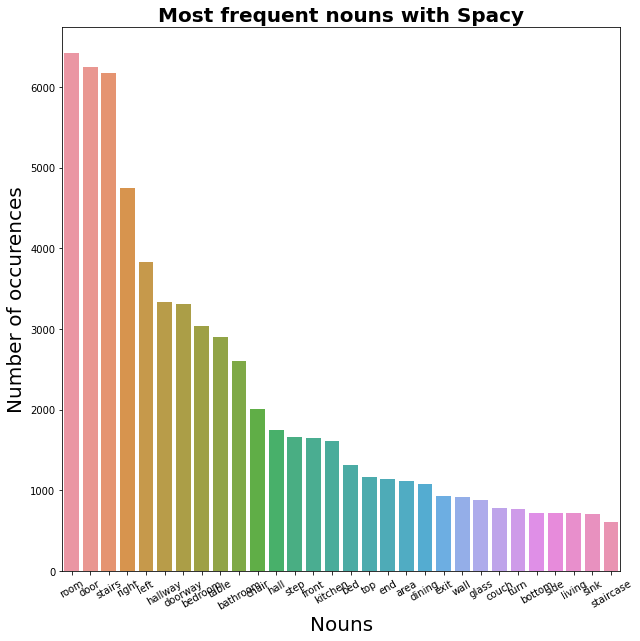

In [9]:
n_frequency = show_frequency(train_n, 30, "Most frequent nouns with Spacy", "Nouns")
%store n_frequency

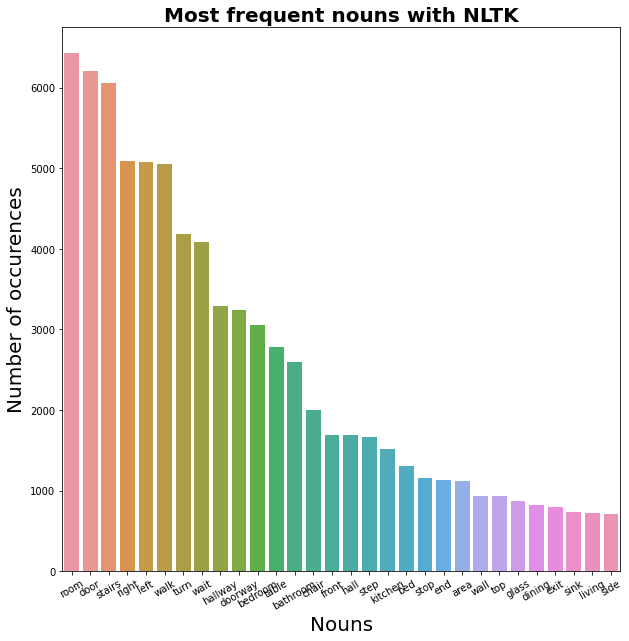

In [10]:
n_frequency

[('room', 6418),
 ('door', 6250),
 ('stairs', 6169),
 ('right', 4750),
 ('left', 3837),
 ('hallway', 3341),
 ('doorway', 3306),
 ('bedroom', 3038),
 ('table', 2907),
 ('bathroom', 2606),
 ('chair', 2009),
 ('hall', 1743),
 ('step', 1663),
 ('front', 1647),
 ('kitchen', 1613),
 ('bed', 1311),
 ('top', 1166),
 ('end', 1143),
 ('area', 1115),
 ('dining', 1085),
 ('exit', 929),
 ('wall', 924),
 ('glass', 877),
 ('couch', 781),
 ('turn', 775),
 ('bottom', 718),
 ('side', 715),
 ('living', 714),
 ('sink', 708),
 ('staircase', 610),
 ('pool', 532),
 ('fireplace', 531),
 ('closet', 505),
 ('way', 496),
 ('house', 461),
 ('rug', 420),
 ('entrance', 418),
 ('desk', 395),
 ('set', 392),
 ('painting', 387),
 ('counter', 374),
 ('patio', 371),
 ('office', 365),
 ('landing', 354),
 ('window', 351),
 ('head', 348),
 ('floor', 337),
 ('corner', 327),
 ('mirror', 324),
 ('bar', 283),
 ('couches', 272),
 ('plant', 265),
 ('stair', 261),
 ('archway', 253),
 ('entryway', 226),
 ('middle', 225),
 ('walk', 

Stored 'np_frequency' (list)


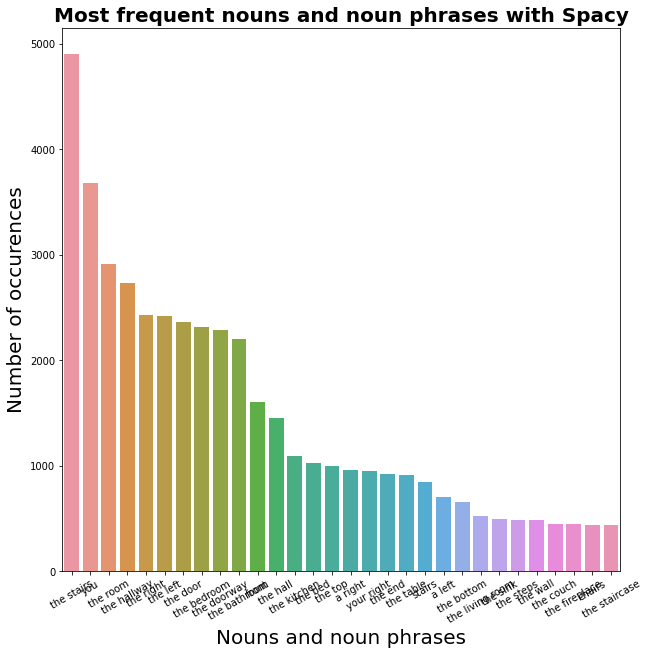

In [11]:
np_frequency = show_frequency(train_np, 30, "Most frequent nouns and noun phrases with Spacy", "Nouns and noun phrases")
%store np_frequency

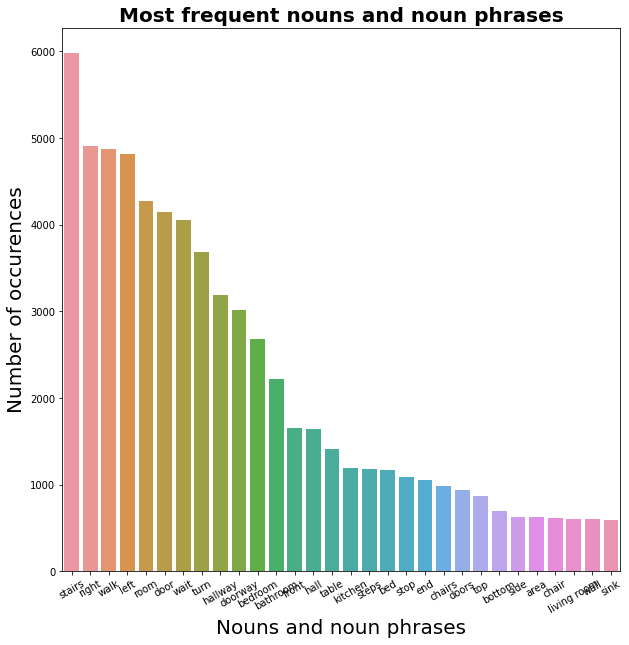

In [12]:
np_frequency

[('the stairs', 4905),
 ('you', 3679),
 ('the room', 2913),
 ('the hallway', 2732),
 ('the right', 2429),
 ('the left', 2417),
 ('the door', 2365),
 ('the bedroom', 2317),
 ('the doorway', 2285),
 ('the bathroom', 2200),
 ('front', 1608),
 ('the hall', 1457),
 ('the kitchen', 1095),
 ('the bed', 1027),
 ('the top', 999),
 ('a right', 958),
 ('your right', 952),
 ('the end', 925),
 ('the table', 911),
 ('stairs', 844),
 ('a left', 710),
 ('the bottom', 660),
 ('the living room', 524),
 ('the sink', 497),
 ('the steps', 485),
 ('the wall', 483),
 ('the couch', 446),
 ('the fireplace', 445),
 ('chairs', 438),
 ('the staircase', 438),
 ('your left', 432),
 ('it', 430),
 ('exit', 417),
 ('the house', 404),
 ('the dining room', 369),
 ('the closet', 337),
 ('the double doors', 320),
 ('turn', 306),
 ('the pool', 304),
 ('the entrance', 297),
 ('the open door', 289),
 ('head', 277),
 ('the first door', 265),
 ('the corner', 238),
 ('doorway', 234),
 ('the dining table', 228),
 ('the laundry r

## Classifying attributes into groups

Synset: a set of synonyms that share a common meaning.

We count how often some attributes (adjectives) are used.
Then, we increase the saliency of the objects that have been described with the most salient attributes.

How to construct noun phrases with attributes:

- semantic parsing and construct the rules manually
- wordnet / look up the synsets if there are any group synsets
- word embeddings, turn words into embeddings and cluster them together
- the main task is to classify objects into groups

In [5]:
def noun_to_wordnet(dataset):
    """Produces wordnet form of nouns from dataset.
    
    Parameters
    ----------
    dataset : dict
        A dictionary of nouns from R2R dataset.
    """
    
    #dataset = sorted(list(set([item for sublist in dataset for item in sublist.split()])))
    dataset = sorted(list([item for sublist in dataset for item in sublist.split()]))
    wn_nouns = []
    
    for token in dataset:
        w_synset = wn.synsets(token)
        if w_synset:
            wn_nouns.append(str(w_synset[0])[8:-2])
    
    #wn_nouns = list(set(wn_nouns))
    wn_nouns = list(wn_nouns)
    
    with open("wordnet_nouns.txt", 'w') as f:
        for w in wn_nouns:
            f.write(w)
            f.write("\n")
        f.close()
    
noun_to_wordnet(train_np)

In [21]:
def desc_to_emb(title,data):
            
    with open(title, 'w') as f:
        writer = csv.writer(f, delimiter='\n')
        writer.writerow(data)
        f.close()
    
desc_to_emb("desc_emb.csv",clean_dataset_split)

In [54]:
def classify_token(dataset):
    """Classifies nouns from dataset with wordnet.
    
    Parameters
    ----------
    dataset : dict
        A dictionary of nouns from R2R dataset.
        
    Returns
    -------
    classes : dict
        Dictionary of classes of nouns and their occurences.
    """
    
    #dataset = sorted(list([item for sublist in dataset for item in sublist.split()]))

    #add or remove set for more accurate results
    dataset = sorted(list(set([item for sublist in dataset for item in sublist.split()])))

    classes = {}
    classes_root = {}
    
    for token in dataset:
        w_synset = wn.synsets(token)
        if w_synset:
            w_synset = w_synset[0]
            
            group = {count:ss for ss, count in w_synset.hypernym_distances()}
                
            if len(group) >= 7:
                group = group[max(group) - 5]
            elif len(group) > 3:
                group = group[max(group) - 2]
            else:
                group = group[0]
            
            if str(group)[8:-7] in classes.keys():
                classes[str(group)[8:-7]] += 1
            else:
                classes[str(group)[8:-7]] = 1
                
            root_group = w_synset.root_hypernyms()[0]
            
            if str(root_group)[8:-7] in classes_root.keys():
                classes_root[str(root_group)[8:-7]] += 1
            else:
                classes_root[str(root_group)[8:-7]] = 1
        else:
            pass
    
    classes = dict(sorted(classes.items(), key=operator.itemgetter(1),reverse=True))
    classes_root = dict(sorted(classes_root.items(), key=operator.itemgetter(1),reverse=True))
    # Remove when only 1 occurence in a class
    print(classes,len(classes))
    return classes

classes_np = classify_token(train_np)

{'instrumentality': 247, 'structure': 128, 'organism': 115, 'object': 60, 'causal_agent': 55, 'activity': 51, 'material': 43, 'attribute': 42, 'way': 39, 'artifact': 36, 'action': 33, 'integer': 31, 'creation': 30, 'covering': 30, 'communication': 29, 'group': 24, 'measure': 23, 'area': 18, 'relation': 18, 'idea': 17, 'matter': 17, 'surface': 17, 'chemical_element': 16, 'thing': 16, 'commodity': 16, 'color': 14, 'geographical_area': 14, 'fabric': 14, 'extremity': 13, 'external_body_part': 12, 'psychological_feature': 12, 'decoration': 11, 'physical_phenomenon': 10, 'nutriment': 10, 'geographic_point': 9, 'space': 8, 'block': 8, 'line': 8, 'whole': 8, 'process': 7, 'sheet': 7, 'fixture': 7, 'metric_unit': 6, 'curve': 6, 'unit': 6, 'plant_part': 6, 'basic_cognitive_process': 6, 'plane_figure': 6, 'article': 6, 'rank': 6, 'building_material': 6, 'movement': 5, 'communicate': 5, 'physical_condition': 5, 'substance': 5, 'physical_entity': 5, 'supply': 5, 'knowledge_domain': 5, 'complex_numb

In [28]:
def get_attributes(dataset):
    
    adj_dataset = {}
    exceptions = []
    
    dict_frequency = Counter(dataset)
    adj_frequency = sorted(dict_frequency.items(), key=operator.itemgetter(1), reverse=True)

    for token in sorted(list(set(dataset))):
        
        word = wn.synsets(str(token))
        
        try:
            word = wn.synset(str(token)+".a.01")

            if token not in adj_dataset:
                adj_dataset[token] = list()
            att = word.attributes()
            if att:
                adj_dataset[token].append(str(att))
            else:
                sim = word.similar_tos()
                if sim:
                    adj_dataset[token].append(str(sim))
                else:
                    exceptions.append(token)
            
        except Exception as e:
            exceptions.append(token)
                    
    return adj_dataset, adj_frequency, exceptions

%store -r np_adj
np_attributes, np_freq_attributes, np_exceptions = get_attributes(np_adj)

In [29]:
np_attributes
"""
We can sort everything by:
- look case by case when more than 1 output
- cut to obtain only word inside synset
ex: 'wavy': ["[Synset('curly.a.01')]"] => curly

Same for objects?
"""

{'11th': ["[Synset('ordinal.a.02')]"],
 '2nd': ["[Synset('ordinal.a.02')]"],
 '3rd': ["[Synset('ordinal.a.02')]"],
 '4th': ["[Synset('ordinal.a.02')]"],
 '5th': ["[Synset('ordinal.a.02')]"],
 '6th': ["[Synset('ordinal.a.02')]"],
 'abstract': ["[Synset('abstractness.n.01')]"],
 'additional': ["[Synset('additive.a.02')]"],
 'adjacent': ["[Synset('close.a.01')]"],
 'adjustable': ["[Synset('adaptable.a.01')]"],
 'alcoholic': ["[Synset('dry.s.14'), Synset('hard.s.10'), Synset('intoxicant.s.01'), Synset('spirituous.s.01'), Synset('wet.s.05')]"],
 'amazing': ["[Synset('surprising.a.01')]"],
 'american': ['[]'],
 'angled': ["[Synset('angular.a.02')]"],
 'arch': ["[Synset('superior.a.02')]"],
 'arched': ['[]'],
 'asian': ['[]'],
 'asleep': ["[Synset('at_rest.s.01'), Synset('dormant.s.01'), Synset('drowsy.s.01'), Synset('fast_asleep.s.01'), Synset('hypnoid.s.01'), Synset('sleepy.s.01'), Synset('slumberous.s.02'), Synset('unawakened.s.02')]"],
 'attached': ["[Synset('related.a.01')]"],
 'attic': 

In [137]:
np_freq_attributes

[('first', 1264),
 ('left', 1076),
 ('open', 806),
 ('double', 680),
 ('white', 658),
 ('large', 615),
 ('second', 567),
 ('next', 493),
 ('right', 440),
 ('wooden', 339),
 ('small', 334),
 ('black', 334),
 ('other', 330),
 ('red', 303),
 ('front', 302),
 ('middle', 280),
 ('laundry', 266),
 ('blue', 251),
 ('last', 207),
 ('long', 206),
 ('brown', 188),
 ('round', 186),
 ('few', 142),
 ('slight', 140),
 ('third', 127),
 ('main', 126),
 ('sharp', 108),
 ('light', 106),
 ('green', 105),
 ('big', 87),
 ('opposite', 85),
 ('far', 81),
 ('potted', 79),
 ('immediate', 76),
 ('arched', 69),
 ('top', 69),
 ('more', 62),
 ('empty', 62),
 ('hard', 56),
 ('purple', 53),
 ('circular', 52),
 ('fourth', 52),
 ('yellow', 50),
 ('narrow', 49),
 ('short', 46),
 ('banister', 46),
 ('gray', 44),
 ('outside', 43),
 ('outdoor', 40),
 ('spiral', 39),
 ('tall', 38),
 ('nearest', 35),
 ('hot', 35),
 ('french', 32),
 ('bottom', 32),
 ('back', 30),
 ('balcony', 30),
 ('pink', 30),
 ('2nd', 29),
 ('single', 29)

In [134]:
wn.synsets('small') #Synset('small.a.01') 
small = wn.synset('small.a.01')
wn.synsets('big') #Synset('large.a.01')
large = wn.synset('large.a.01')

large.lemmas()[0].antonyms()
large.path_similarity(small)
large.wup_similarity(small)
red = wn.synset('yellow.a.01')
print(red.similar_tos())
#colour = wn.synset('color.n.01')
#colour.hyponyms()

[Synset('chromatic.a.03')] [] []


In [36]:
for token in sorted(list(np_adj2)):
    w_synsets = wn.synsets(token)
    for sn in w_synsets:
        print(sn)
        for ss, count in sn.hypernym_distances():
             print ("\t",ss,'\t', count)

<class 'str'>
<class 'str'>
Synset('eleventh.s.01')
	 Synset('eleventh.s.01') 	 0
<class 'str'>
Synset('eleventh.s.01')
	 Synset('eleventh.s.01') 	 0
<class 'str'>
Synset('second.s.01')
	 Synset('second.s.01') 	 0
<class 'str'>
Synset('second.s.01')
	 Synset('second.s.01') 	 0
<class 'str'>
Synset('second.s.01')
	 Synset('second.s.01') 	 0
<class 'str'>
Synset('second.s.01')
	 Synset('second.s.01') 	 0
<class 'str'>
Synset('second.s.01')
	 Synset('second.s.01') 	 0
<class 'str'>
Synset('second.s.01')
	 Synset('second.s.01') 	 0
<class 'str'>
Synset('second.s.01')
	 Synset('second.s.01') 	 0
<class 'str'>
Synset('second.s.01')
	 Synset('second.s.01') 	 0
<class 'str'>
Synset('second.s.01')
	 Synset('second.s.01') 	 0
<class 'str'>
Synset('second.s.01')
	 Synset('second.s.01') 	 0
<class 'str'>
Synset('second.s.01')
	 Synset('second.s.01') 	 0
<class 'str'>
Synset('second.s.01')
	 Synset('second.s.01') 	 0
<class 'str'>
Synset('second.s.01')
	 Synset('second.s.01') 	 0
<class 'str'>
Syns

	 Synset('auditory_communication.n.01') 	 3
	 Synset('dialect.n.01') 	 0
	 Synset('entity.n.01') 	 6
	 Synset('speech.n.02') 	 2
	 Synset('non-standard_speech.n.01') 	 1
	 Synset('communication.n.02') 	 4
Synset('stress.n.01')
	 Synset('abstraction.n.06') 	 5
	 Synset('manner_of_speaking.n.01') 	 2
	 Synset('entity.n.01') 	 6
	 Synset('expressive_style.n.01') 	 3
	 Synset('stress.n.01') 	 0
	 Synset('prosody.n.01') 	 1
	 Synset('communication.n.02') 	 4
Synset('accent.n.05')
	 Synset('diacritical_mark.n.01') 	 1
	 Synset('signal.n.01') 	 5
	 Synset('mark.n.10') 	 2
	 Synset('communication.n.02') 	 6
	 Synset('accent.n.05') 	 0
	 Synset('entity.n.01') 	 8
	 Synset('abstraction.n.06') 	 7
	 Synset('written_symbol.n.01') 	 3
	 Synset('symbol.n.01') 	 4
Synset('stress.v.01')
	 Synset('interact.v.01') 	 7
	 Synset('communicate.v.02') 	 6
	 Synset('inform.v.01') 	 5
	 Synset('tell.v.02') 	 4
	 Synset('act.v.01') 	 8
	 Synset('stress.v.01') 	 0
	 Synset('convey.v.01') 	 2
	 Synset('impart.v.0

	 Synset('shape.n.02') 	 3
	 Synset('attribute.n.02') 	 4
	 Synset('curve.n.01') 	 1
	 Synset('line.n.04') 	 2
Synset('arch.n.02')
	 Synset('skeletal_structure.n.01') 	 1
	 Synset('entity.n.01') 	 7
	 Synset('structure.n.04') 	 2
	 Synset('thing.n.12') 	 5
	 Synset('physical_entity.n.01') 	 6
	 Synset('body_part.n.01') 	 3
	 Synset('arch.n.02') 	 0
	 Synset('part.n.03') 	 4
Synset('arch.n.03')
	 Synset('whole.n.02') 	 5
	 Synset('physical_entity.n.01') 	 7
	 Synset('object.n.01') 	 6
	 Synset('access.n.03') 	 2
	 Synset('arch.n.03') 	 0
	 Synset('entrance.n.01') 	 1
	 Synset('entity.n.01') 	 8
	 Synset('artifact.n.01') 	 4
	 Synset('way.n.06') 	 3
Synset('arch.n.04')
	 Synset('object.n.01') 	 4
	 Synset('entity.n.01') 	 6
	 Synset('whole.n.02') 	 3
	 Synset('physical_entity.n.01') 	 5
	 Synset('structure.n.01') 	 1
	 Synset('artifact.n.01') 	 2
	 Synset('arch.n.04') 	 0
Synset('arch.v.01')
	 Synset('arch.v.01') 	 0
	 Synset('change.v.02') 	 3
	 Synset('bend.v.01') 	 1
	 Synset('change_

<class 'str'>
Synset('arch.v.01')
	 Synset('arch.v.01') 	 0
	 Synset('change.v.02') 	 3
	 Synset('bend.v.01') 	 1
	 Synset('change_shape.v.01') 	 2
Synset('arched.a.01')
	 Synset('arched.a.01') 	 0
Synset('arced.s.01')
	 Synset('arced.s.01') 	 0
<class 'str'>
Synset('arch.v.01')
	 Synset('arch.v.01') 	 0
	 Synset('change.v.02') 	 3
	 Synset('bend.v.01') 	 1
	 Synset('change_shape.v.01') 	 2
Synset('arched.a.01')
	 Synset('arched.a.01') 	 0
Synset('arced.s.01')
	 Synset('arced.s.01') 	 0
<class 'str'>
Synset('arch.v.01')
	 Synset('arch.v.01') 	 0
	 Synset('change.v.02') 	 3
	 Synset('bend.v.01') 	 1
	 Synset('change_shape.v.01') 	 2
Synset('arched.a.01')
	 Synset('arched.a.01') 	 0
Synset('arced.s.01')
	 Synset('arced.s.01') 	 0
<class 'str'>
Synset('arch.v.01')
	 Synset('arch.v.01') 	 0
	 Synset('change.v.02') 	 3
	 Synset('bend.v.01') 	 1
	 Synset('change_shape.v.01') 	 2
Synset('arched.a.01')
	 Synset('arched.a.01') 	 0
Synset('arced.s.01')
	 Synset('arced.s.01') 	 0
<class 'str'>
Sy

	 Synset('second.v.01') 	 0
Synset('back.v.04')
	 Synset('back.v.04') 	 0
Synset('back.v.05')
	 Synset('transfer.v.05') 	 4
	 Synset('give.v.03') 	 3
	 Synset('finance.v.01') 	 1
	 Synset('pay.v.01') 	 2
	 Synset('back.v.05') 	 0
Synset('back.v.06')
	 Synset('back.v.06') 	 0
	 Synset('be.v.03') 	 2
	 Synset('lie.v.01') 	 1
Synset('bet_on.v.01')
	 Synset('bet.v.02') 	 1
	 Synset('compete.v.01') 	 4
	 Synset('play.v.01') 	 3
	 Synset('bet_on.v.01') 	 0
	 Synset('gamble.v.02') 	 2
Synset('back.v.08')
	 Synset('change.v.01') 	 2
	 Synset('switch.v.04') 	 1
	 Synset('back.v.08') 	 0
Synset('back.v.09')
	 Synset('confirm.v.01') 	 1
	 Synset('back.v.09') 	 0
Synset('back.v.10')
	 Synset('change.v.02') 	 2
	 Synset('back.v.10') 	 0
	 Synset('strengthen.v.02') 	 1
Synset('back.a.01')
	 Synset('back.a.01') 	 0
Synset('back.s.02')
	 Synset('back.s.02') 	 0
Synset('back.s.03')
	 Synset('back.s.03') 	 0
Synset('back.r.01')
	 Synset('back.r.01') 	 0
Synset('back.r.02')
	 Synset('back.r.02') 	 0
Syns

	 Synset('surface.n.01') 	 2
	 Synset('entity.n.01') 	 7
	 Synset('rear.n.05') 	 0
Synset('back.n.03')
	 Synset('position.n.01') 	 1
	 Synset('object.n.01') 	 4
	 Synset('physical_entity.n.01') 	 5
	 Synset('point.n.02') 	 2
	 Synset('back.n.03') 	 0
	 Synset('location.n.01') 	 3
	 Synset('entity.n.01') 	 6
Synset('back.n.04')
	 Synset('back.n.04') 	 0
	 Synset('causal_agent.n.01') 	 5
	 Synset('whole.n.02') 	 7
	 Synset('organism.n.01') 	 5
	 Synset('object.n.01') 	 8
	 Synset('living_thing.n.01') 	 6
	 Synset('physical_entity.n.01') 	 9
	 Synset('physical_entity.n.01') 	 6
	 Synset('football_player.n.01') 	 1
	 Synset('contestant.n.01') 	 3
	 Synset('athlete.n.01') 	 2
	 Synset('person.n.01') 	 4
	 Synset('entity.n.01') 	 7
	 Synset('entity.n.01') 	 10
	 Synset('player.n.01') 	 2
Synset('spinal_column.n.01')
	 Synset('skeletal_structure.n.01') 	 1
	 Synset('structure.n.04') 	 2
	 Synset('thing.n.12') 	 5
	 Synset('physical_entity.n.01') 	 6
	 Synset('body_part.n.01') 	 3
	 Synset('pa

KeyboardInterrupt: 

In [31]:
np_adj2 = np_adj